# PCA Reduction and model training

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression as LR

First we preprocess the data in order to perform the PCA reduction over the selected data

In [6]:
directorio = '../newfile/latpar_project/LatPars_SuperModel/'

hfxrd = np.load(directorio + 'hf_0100.npy')
y = np.load('../newfile/latpar_project/latpars.npy')

db = pd.read_csv('../newfile/latpar_project/db_peaks.csv')

dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

for row in range(db.shape[0]):    
    db.at[row,'name'] = db['name'][row][:7]
    
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

for row in range(dftest.shape[0]):
    dftest.at[row, 'name'] = dftest['name'][row][:7]
    
for row in range(dftraval.shape[0]):
    dftraval.at[row, 'name'] = dftraval['name'][row][:7]

ntest = dftest.shape[0]//4
ntraval = dftraval.shape[0]//4

dftest = dftest.iloc[:ntest,:].reset_index(drop=True)
dftraval = dftraval.iloc[:ntraval,:].reset_index(drop=True)

idxtraval = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftraval.name.values])].index]
idxtest = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftest.name.values])].index]


hftest = hfxrd[idxtest]
hftraval = hfxrd[idxtraval]
    
ytest = y[idxtest]
ytraval = y[idxtraval]

In [7]:
hftraval.shape

(205331, 480)

In [8]:
dbtest = db.take(idxtest).reset_index(drop=True)
dbtraval = db.take(idxtraval).reset_index(drop=True)

In [9]:
sgdiccio = pd.read_csv('../newfile/latpar_project/sgnum_cif.csv')
sgdiccio = {k:v for k,v in zip(sgdiccio.cif.values, sgdiccio.sgnum.values)}

dbtest = db.take(idxtest).reset_index(drop=True)
dbtraval = db.take(idxtraval).reset_index(drop=True)

dbtest['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtest.name.values]
dbtraval['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtraval.name.values]

sgoset = scipy.stats.ortho_group.rvs(230, random_state=3451)
sgos_traval = sgoset[dbtraval.sgnum.values-1]
sgos_test = sgoset[dbtest.sgnum.values-1]

In [10]:
cs = dict()

for n in range(1,231):
    
    if n <= 2: cs[n]  = 0;
    elif 2 < n <=15: cs[n] = 1;
    elif 15 < n <=74: cs[n] = 2;
    elif 74 < n <=142: cs[n] = 3;
    elif 142 < n <=167: cs[n] = 4;
    elif 167 < n <=194: cs[n] = 5;
    elif 194 < n <=230: cs[n] = 6;

dbtest['cs'] = [cs.get(i, None) for i in dbtest.sgnum.values]
dbtraval['cs'] = [cs.get(i, None) for i in dbtraval.sgnum.values]

orthoset = scipy.stats.ortho_group.rvs(32, random_state=3451)
csos_test = orthoset[dbtest.cs.values]
csos_traval = orthoset[dbtraval.cs.values]

#### PCA For hftraval and hftest

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [12]:
pcatraval = PCA()

pcatraval.fit(hftraval)

xtrans_traval = pcatraval.transform(hftraval)
xtrans_test = pcatraval.transform(hftest)

vartraval = pcatraval.explained_variance_ratio_

cum_traval = np.cumsum(vartraval)

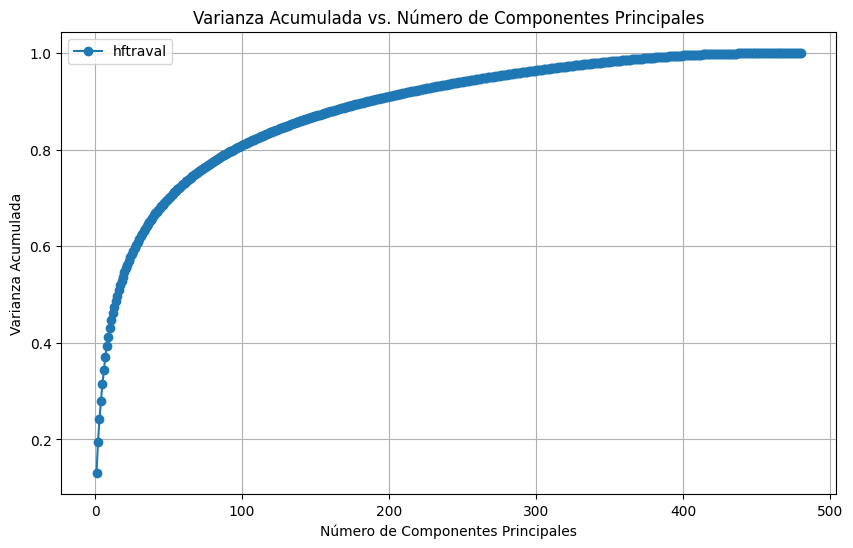

In [13]:
# Graficar la varianza acumulada contra el número de componentes principales
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_traval) + 1), cum_traval, marker='o', linestyle='-', label='hftraval')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Acumulada vs. Número de Componentes Principales')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#componentes mayores al 80% de la varianza
vartraval_80 = xtrans_traval[:, cum_traval <= 0.8]

#componentes mayores al 95% de la varianza
vartraval_95 = xtrans_traval[:, cum_traval <= 0.95]

# Equivalentes test
vartest_80 = xtrans_test[:, cum_traval <= 0.8]
vartest_95 = xtrans_test[:, cum_traval <= 0.95]

In [15]:
print(f"Number of components needed to retain 80% variance: {vartraval_80.shape[1]} \nNumber of components needed to retain 95% variance: {vartraval_95.shape[1]}")

Number of components needed to retain 80% variance: 93 
Number of components needed to retain 95% variance: 267


In [16]:
vartraval_95.shape, vartraval_80.shape

((205331, 267), (205331, 93))

# Model training with PCA

Now, we are going to replicate the Models_extension and Models_extension_wo_xrd neural networks with the pca transformed variables.

In [17]:
# Model Settings

multiples = [6,8]
epochs = 25
batch_size = 64
verbose = 1
dropout = 0.5

def create_mlp(features = int, multiples = list, dropout = 0, name= 'multilayer_nn'):
    input_layer = tf.keras.Input((features,))

    for n, hl in enumerate(multiples):

        if n == 0: x = tf.keras.layers.Dense(hl*features)(input_layer)
        else: x = tf.keras.layers.Dense(hl*features)(x)

        x = tf.keras.layers.LayerNormalization()(x)

        if n != len(multiples) -1:
            x = tf.keras.layers.LeakyReLU(0.15)(x)
            x = tf.keras.layers.Dropout(dropout)(x)

    xs = tf.keras.layers.Dense(multiples[-1]*features)(input_layer)
    xs = tf.keras.layers.LayerNormalization()(xs)

    x = tf.keras.layers.Add()([x, xs])
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(6)(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=x, name=name)


In [18]:
# Model Settings

multiples = [6,8]
epochs = 25
batch_size = 64
verbose = 1
dropout = 0.5

#### Raw PCA 80% variance

Epoch 1/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - MeanSquaredError: 2.7140 - loss: 0.5549 - val_MeanSquaredError: 0.6996 - val_loss: 0.1964
Epoch 2/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - MeanSquaredError: 0.6008 - loss: 0.2046 - val_MeanSquaredError: 0.6227 - val_loss: 0.1697
Epoch 3/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - MeanSquaredError: 0.5089 - loss: 0.1788 - val_MeanSquaredError: 0.6036 - val_loss: 0.1631
Epoch 4/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - MeanSquaredError: 0.4597 - loss: 0.1654 - val_MeanSquaredError: 0.5831 - val_loss: 0.1557
Epoch 5/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - MeanSquaredError: 0.4313 - loss: 0.1572 - val_MeanSquaredError: 0.5778 - val_loss: 0.1520
Epoch 6/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - MeanSquaredError: 0.4078 - loss: 0.1501 - val_MeanSquaredError: 0.5692 - val_loss: 0.1493
Epoch 7/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - MeanSquaredError: 0.3925 - loss: 0.1455 - val_MeanSquaredErro

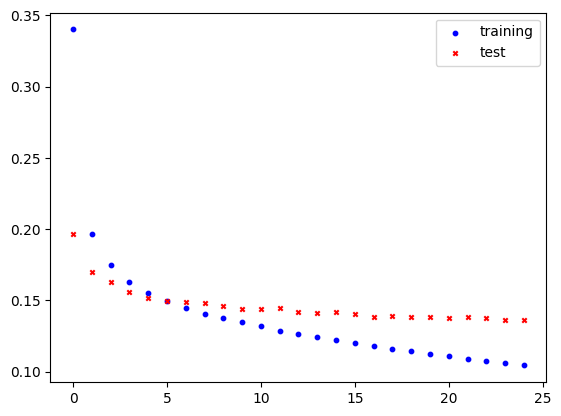

In [20]:
features = vartraval_80.shape[-1]


modelo_pca80 = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_80')


modelo_pca80.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, learning_rate=1e-3, decay=1e-8,))

saveas = 'model_pca_80'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.keras', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca80.fit(vartraval_80,ytraval, validation_data=(vartest_80,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

#### Raw PCA 95

Epoch 1/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 132s 41ms/step - MeanSquaredError: 1.7851 - loss: 0.4386 - val_MeanSquaredError: 0.6260 - val_loss: 0.1734
Epoch 2/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 126s 39ms/step - MeanSquaredError: 0.3471 - loss: 0.1324 - val_MeanSquaredError: 0.5740 - val_loss: 0.1553
Epoch 3/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 126s 39ms/step - MeanSquaredError: 0.2907 - loss: 0.1135 - val_MeanSquaredError: 0.5575 - val_loss: 0.1479
Epoch 4/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 127s 39ms/step - MeanSquaredError: 0.2597 - loss: 0.1037 - val_MeanSquaredError: 0.5462 - val_loss: 0.1431
Epoch 5/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 120s 37ms/step - MeanSquaredError: 0.2445 - loss: 0.0978 - val_MeanSquaredError: 0.5504 - val_loss: 0.1452
Epoch 6/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 120s 37ms/step - MeanSquaredError: 0.2301 - loss: 0.0934 - val_MeanSquaredError: 0.5375 - val_loss: 0.1392
Epoch 7/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 119s 37ms/step - MeanSquaredError: 0.2257 - loss: 0.0910 - val_M

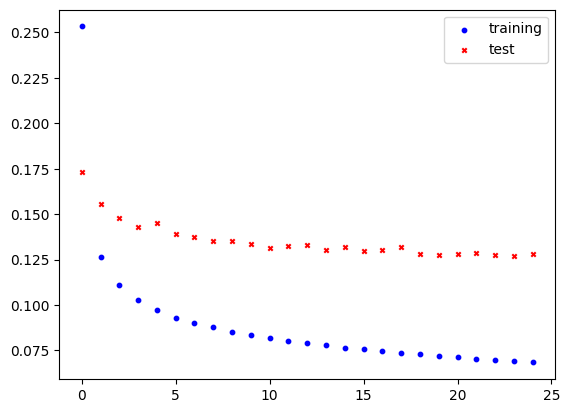

In [20]:
features = vartraval_95.shape[-1]


modelo_pca95 = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_95')


modelo_pca95.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, learning_rate=1e-3, decay=1e-8,))

saveas = 'model_pca_95'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.keras', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca95.fit(vartraval_95,ytraval, validation_data=(vartest_95,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

In [25]:
modelo_pca80 = tf.keras.models.load_model('model_pca_80.keras')
modelo_pca95 = tf.keras.models.load_model('model_pca_95.keras')


483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


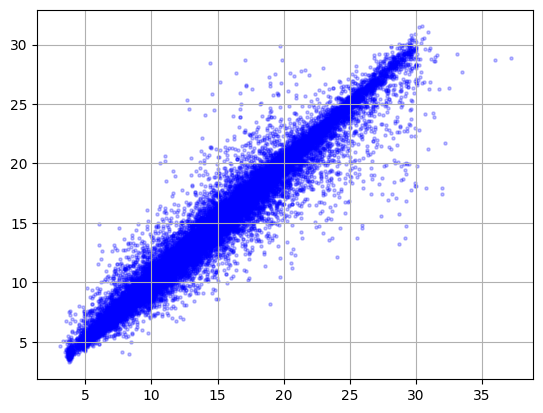

1.022568445424045
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


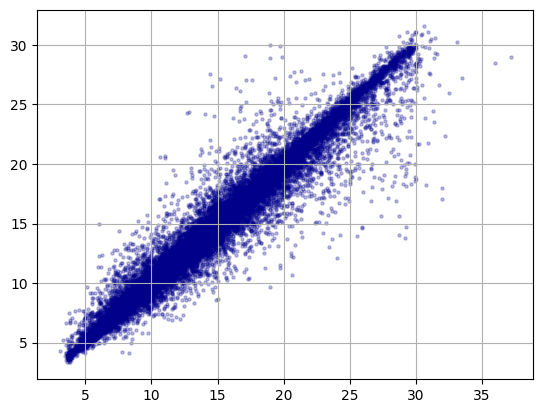

0.9958133384552882


In [26]:
ptestnn = modelo_pca80.predict(vartest_80)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='blue', alpha=0.25)
plt.grid()
plt.show()
    
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(rmse)

ptestnn = modelo_pca95.predict(vartest_95)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='darkblue', alpha=0.25)
plt.grid()
plt.show()
    
print(rmse)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


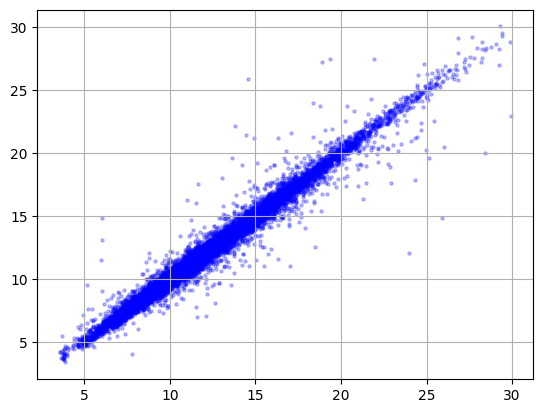

0.6010985322628999
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


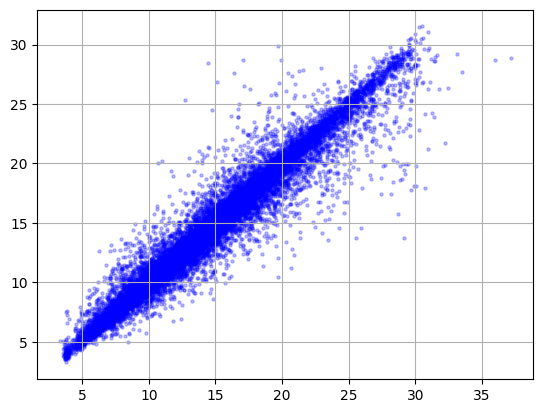

1.18142596600852
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


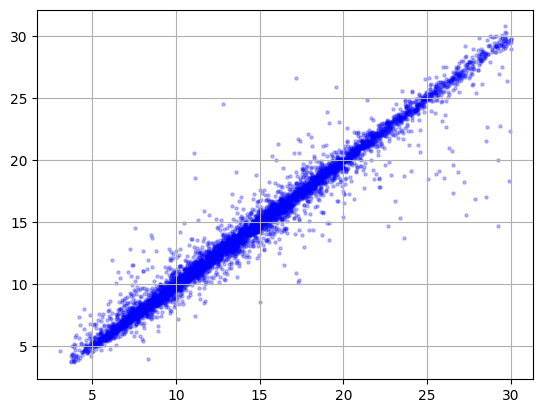

0.9778819330985208
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


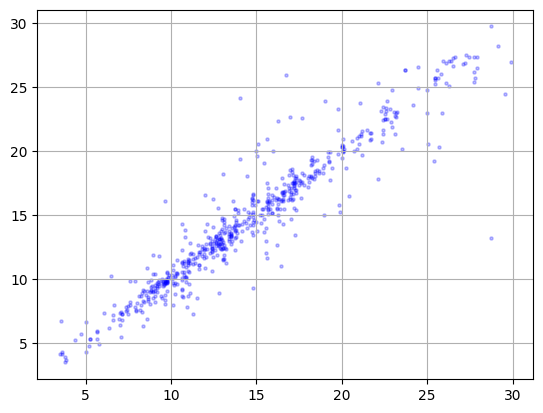

1.687827732399529
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


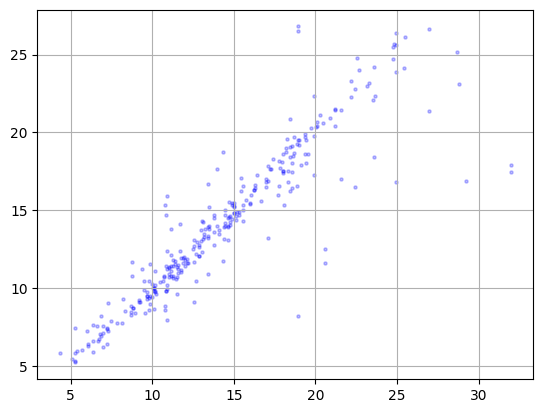

2.2574127251500413
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


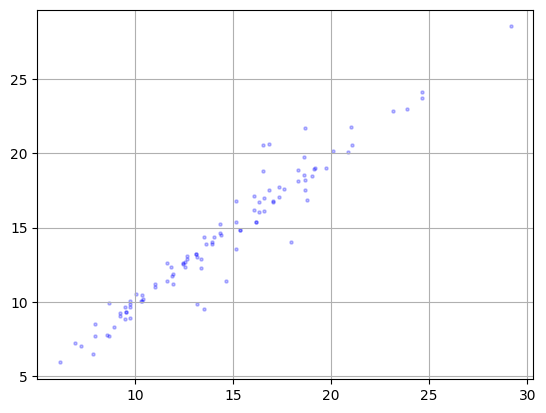

1.1592568492988464
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


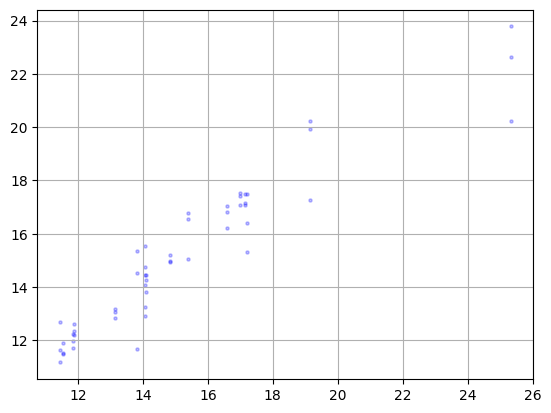

1.1320217079374002
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


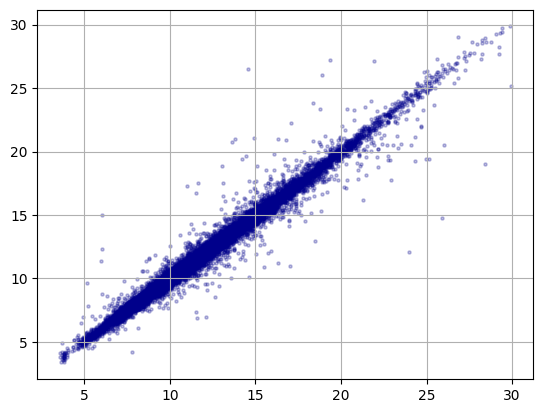

0.5732065082869101
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


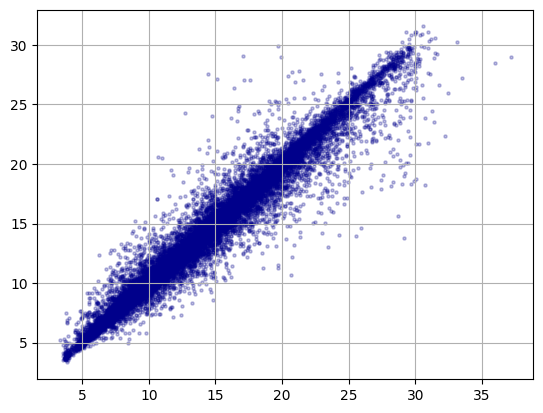

1.1524417697062468
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


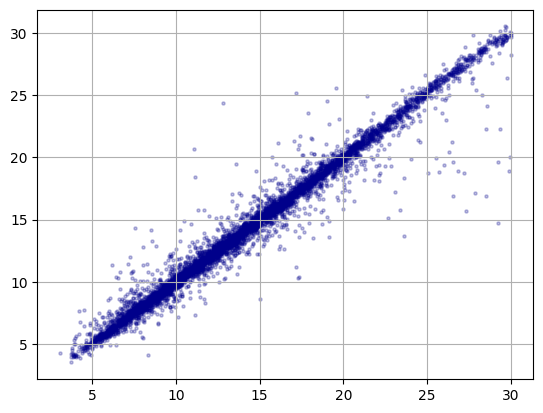

0.9482276679871114
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


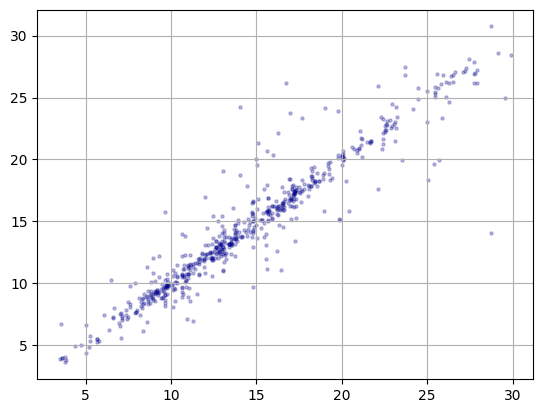

1.6779470481721923
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


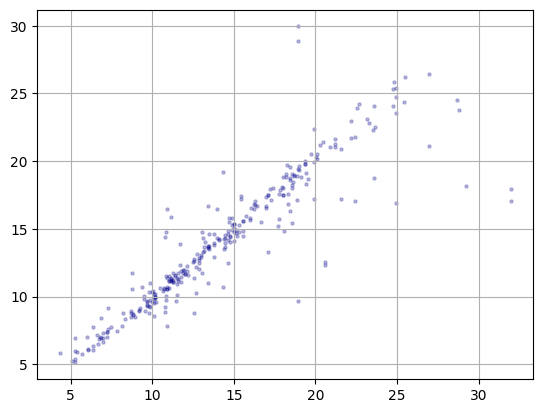

2.2788401094769792
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


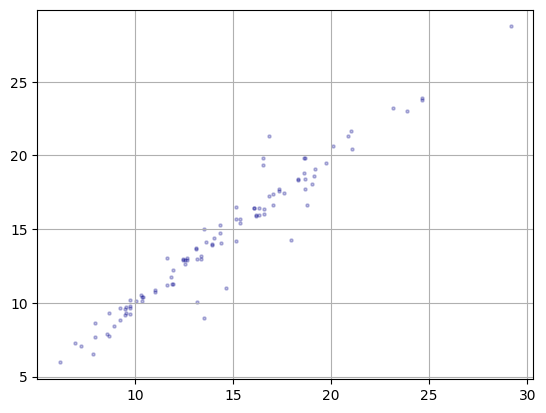

1.137822878986414
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


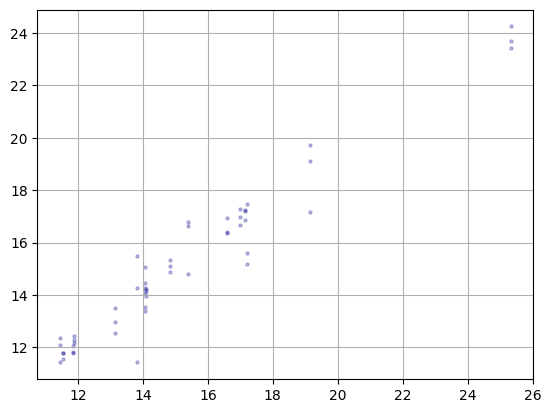

0.8434603737833752


In [30]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : vartest_80[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca80.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='blue', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : vartest_95[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca95.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='darkblue', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

# Modelos PCA + space groups

##### Modelo pca 80 + space groups

In [46]:
spgtest80 = np.concatenate((vartest_80, sgos_test), axis=-1)
spgtraval80 = np.concatenate((vartraval_80, sgos_traval), axis=-1)

Epoch 1/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 196s 61ms/step - MeanSquaredError: 1.7163 - loss: 0.4231 - val_MeanSquaredError: 0.5922 - val_loss: 0.1620
Epoch 2/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 190s 59ms/step - MeanSquaredError: 0.3332 - loss: 0.1263 - val_MeanSquaredError: 0.5575 - val_loss: 0.1496
Epoch 3/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 189s 59ms/step - MeanSquaredError: 0.2757 - loss: 0.1085 - val_MeanSquaredError: 0.5530 - val_loss: 0.1477
Epoch 4/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 189s 59ms/step - MeanSquaredError: 0.2536 - loss: 0.1007 - val_MeanSquaredError: 0.5295 - val_loss: 0.1395
Epoch 5/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 186s 58ms/step - MeanSquaredError: 0.2374 - loss: 0.0954 - val_MeanSquaredError: 0.5325 - val_loss: 0.1388
Epoch 6/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 174s 54ms/step - MeanSquaredError: 0.2298 - loss: 0.0921 - val_MeanSquaredError: 0.5250 - val_loss: 0.1378
Epoch 7/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 174s 54ms/step - MeanSquaredError: 0.2202 - loss: 0.0888 - val_M

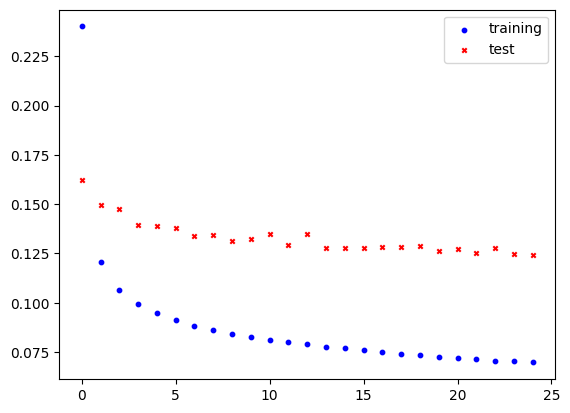

In [47]:
features = spgtraval80.shape[-1]


modelo_pca80_spg = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_80_spg')


modelo_pca80_spg.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, learning_rate=1e-3, decay=1e-8,))

saveas = 'modelo_pca80_spg'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.keras', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca80_spg.fit(spgtraval80,ytraval, validation_data=(spgtest80,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

##### Modelo pca 95 + space groups

In [48]:
spgtest95 = np.concatenate((vartest_95, sgos_test), axis=-1)
spgtraval95 = np.concatenate((vartraval_95, sgos_traval), axis=-1)

Epoch 1/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 338s 105ms/step - MeanSquaredError: 2.0323 - loss: 0.4688 - val_MeanSquaredError: 0.5976 - val_loss: 0.1673
Epoch 2/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 337s 105ms/step - MeanSquaredError: 0.2957 - loss: 0.1158 - val_MeanSquaredError: 0.5541 - val_loss: 0.1506
Epoch 3/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 337s 105ms/step - MeanSquaredError: 0.2395 - loss: 0.0969 - val_MeanSquaredError: 0.5349 - val_loss: 0.1430
Epoch 4/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 337s 105ms/step - MeanSquaredError: 0.2156 - loss: 0.0885 - val_MeanSquaredError: 0.5449 - val_loss: 0.1475
Epoch 5/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 338s 105ms/step - MeanSquaredError: 0.1999 - loss: 0.0829 - val_MeanSquaredError: 0.5194 - val_loss: 0.1358
Epoch 6/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 338s 105ms/step - MeanSquaredError: 0.1879 - loss: 0.0786 - val_MeanSquaredError: 0.5160 - val_loss: 0.1347
Epoch 7/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 337s 105ms/step - MeanSquaredError: 0.1809 - loss: 0.0755 

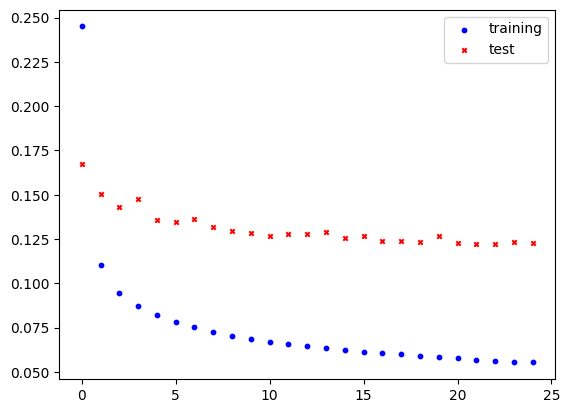

In [49]:
features = spgtraval95.shape[-1]


modelo_pca95_spg = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_80_spg')


modelo_pca95_spg.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, learning_rate=1e-3, decay=1e-8,))

saveas = 'modelo_pca95_spg'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.keras', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca95_spg.fit(spgtraval95,ytraval, validation_data=(spgtest95,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

In [50]:
modelo_pca80_spg = tf.keras.models.load_model('modelo_pca80_spg.keras')
modelo_pca95_spg = tf.keras.models.load_model('modelo_pca95_spg.keras')


483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


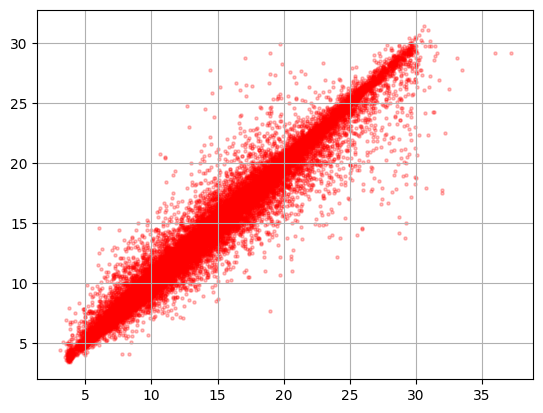

0.9807943320589163
483/483 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


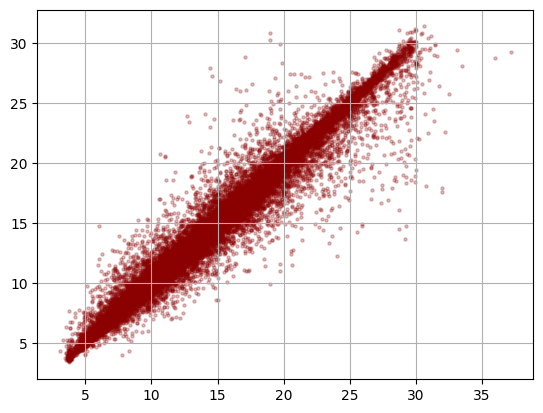

0.9710327098138565


In [51]:
ptestnn = modelo_pca80_spg.predict(spgtest80)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='red', alpha=0.25)
plt.grid()
plt.show()
    
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(rmse)

ptestnn = modelo_pca95_spg.predict(spgtest95)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='darkred', alpha=0.25)
plt.grid()
plt.show()
    
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(rmse)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


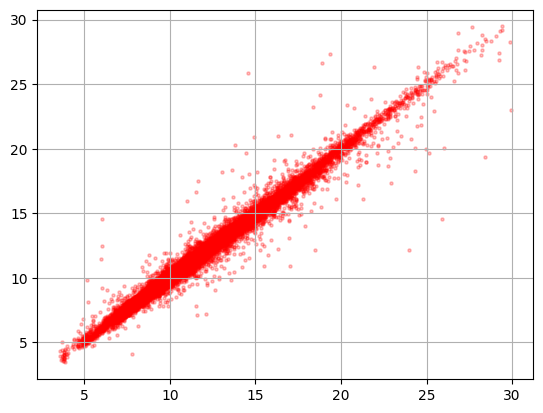

0.5645221527228125
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


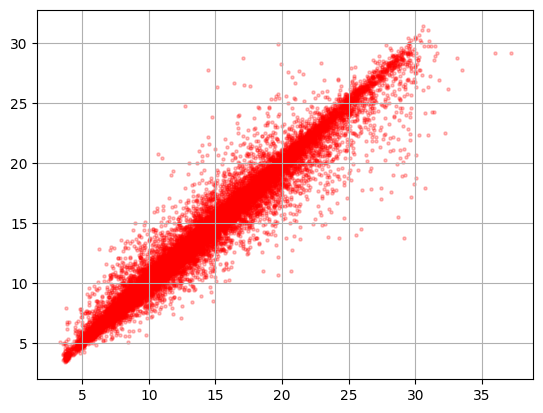

1.1376618834050045
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


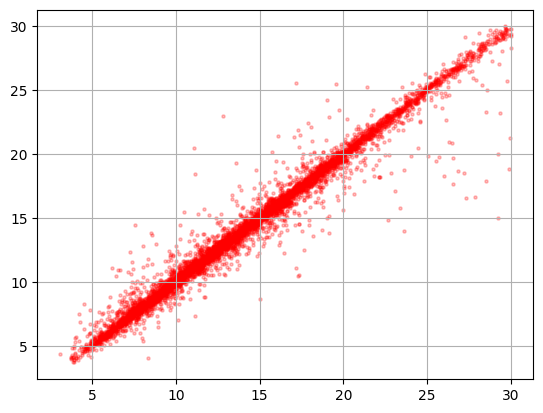

0.9330984968640402
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


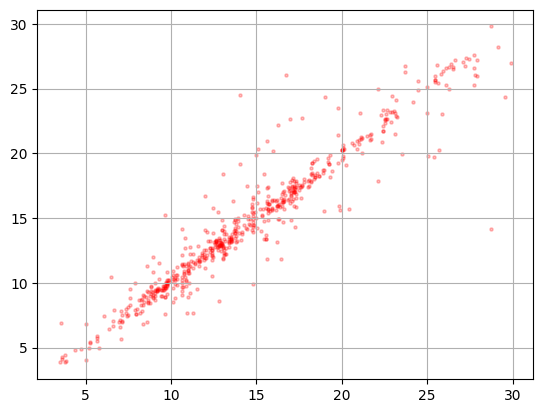

1.5987063380964879
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


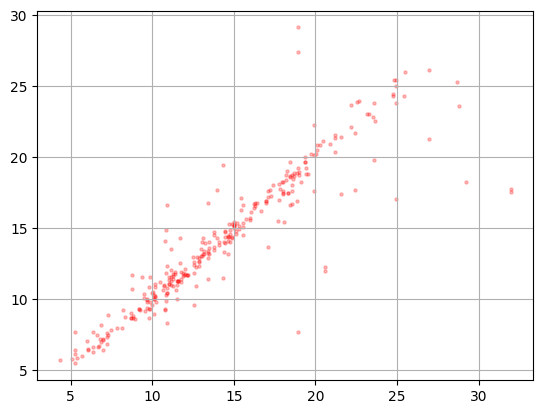

2.2169538070863886
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


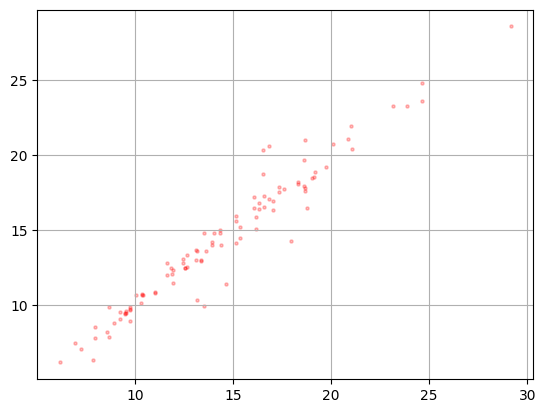

1.094642268155833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


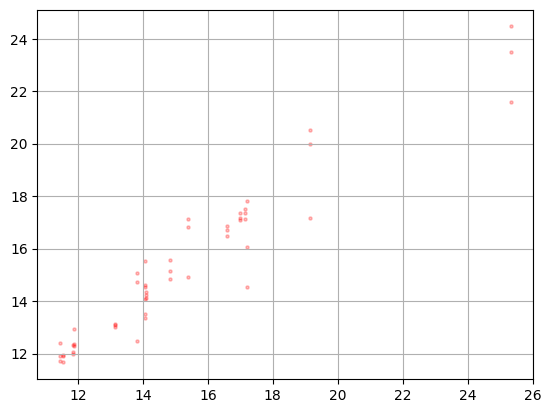

0.998282638830588
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


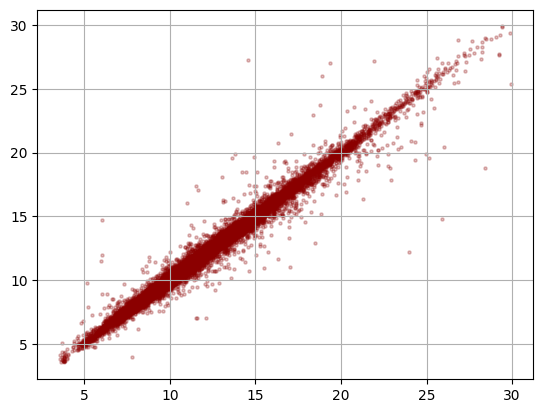

0.5555644947723752
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


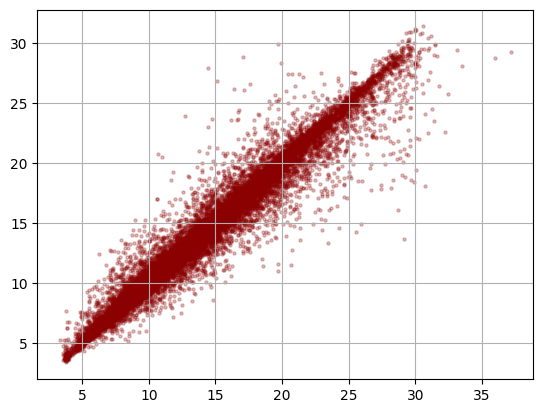

1.1274857617304572
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


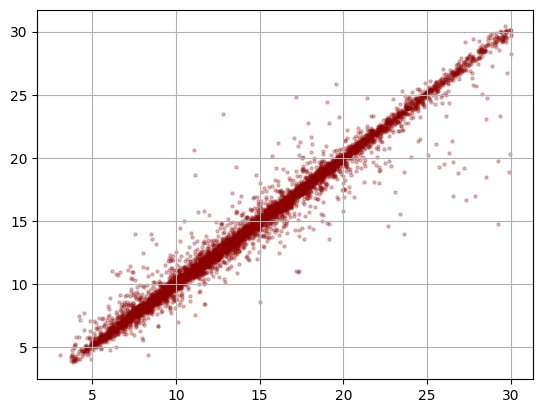

0.9126917074001677
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


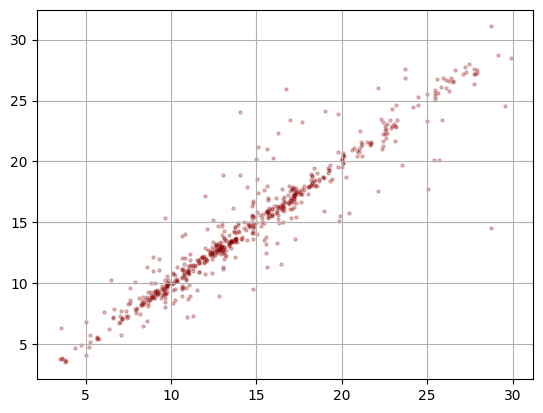

1.627114154264949
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


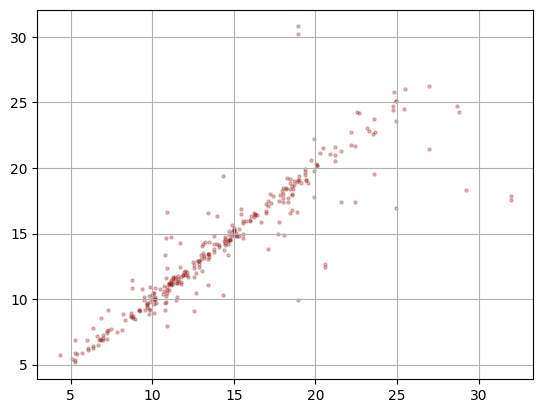

2.2356697114562167
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


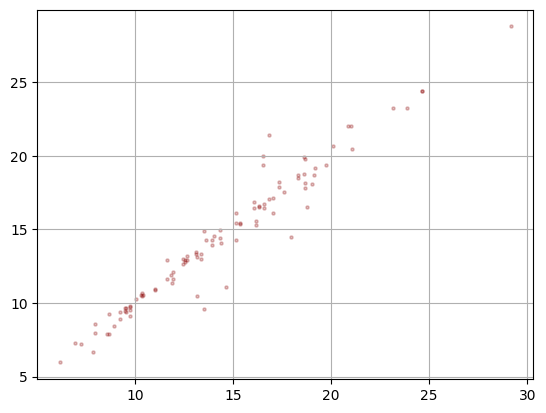

1.0955081075856097
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


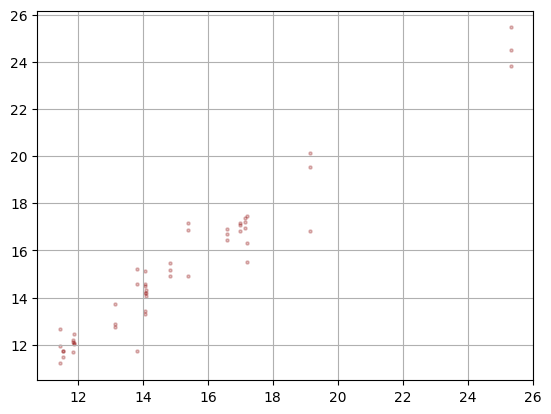

0.7925720468309435


In [52]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : spgtest80[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca80_spg.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='red', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : spgtest95[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca95_spg.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='darkred', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

# Modelos PCA +crystal systems

#### Modelo PCA 80 + crystal systems

In [53]:
rctest80 = np.concatenate((vartest_80, csos_test), axis=-1)
rctraval80 = np.concatenate((vartraval_80, csos_traval), axis=-1)

Epoch 1/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - MeanSquaredError: 2.1837 - loss: 0.4930 - val_MeanSquaredError: 0.6524 - val_loss: 0.1825
Epoch 2/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - MeanSquaredError: 0.4985 - loss: 0.1769 - val_MeanSquaredError: 0.6063 - val_loss: 0.1669
Epoch 3/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - MeanSquaredError: 0.4233 - loss: 0.1547 - val_MeanSquaredError: 0.5818 - val_loss: 0.1569
Epoch 4/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - MeanSquaredError: 0.3824 - loss: 0.1423 - val_MeanSquaredError: 0.5613 - val_loss: 0.1489
Epoch 5/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - MeanSquaredError: 0.3548 - loss: 0.1342 - val_MeanSquaredError: 0.5569 - val_loss: 0.1482
Epoch 6/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - MeanSquaredError: 0.3399 - loss: 0.1290 - val_MeanSquaredError: 0.5504 - val_loss: 0.1450
Epoch 7/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - MeanSquaredError: 0.3280 - loss: 0.1255 - val_MeanSqua

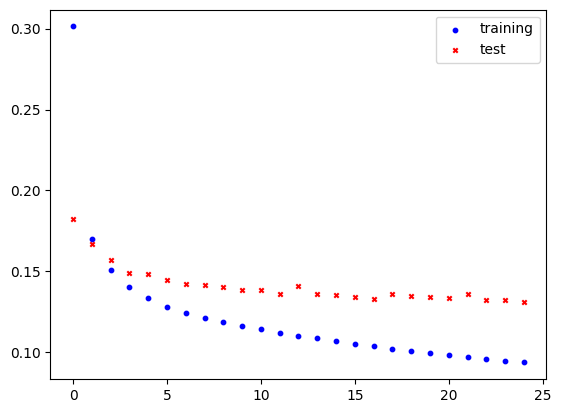

In [54]:
features = rctest80.shape[-1]


modelo_pca80_cs = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_80_cs')


modelo_pca80_cs.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, learning_rate=1e-3, decay=1e-8,))

saveas = 'modelo_pca80_cs'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.keras', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca80_cs.fit(rctraval80,ytraval, validation_data=(rctest80,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

#### Modelo PCA 95 + crystal systems

In [55]:
rctest95 = np.concatenate((vartest_95, csos_test), axis=-1)
rctraval95 = np.concatenate((vartraval_95, csos_traval), axis=-1)

Epoch 1/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 149s 46ms/step - MeanSquaredError: 1.6669 - loss: 0.4240 - val_MeanSquaredError: 0.6106 - val_loss: 0.1692
Epoch 2/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 152s 48ms/step - MeanSquaredError: 0.3358 - loss: 0.1286 - val_MeanSquaredError: 0.5630 - val_loss: 0.1498
Epoch 3/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 153s 48ms/step - MeanSquaredError: 0.2809 - loss: 0.1096 - val_MeanSquaredError: 0.5460 - val_loss: 0.1456
Epoch 4/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 152s 47ms/step - MeanSquaredError: 0.2485 - loss: 0.1000 - val_MeanSquaredError: 0.5473 - val_loss: 0.1481
Epoch 5/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 152s 47ms/step - MeanSquaredError: 0.2334 - loss: 0.0939 - val_MeanSquaredError: 0.5285 - val_loss: 0.1382
Epoch 6/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 152s 47ms/step - MeanSquaredError: 0.2184 - loss: 0.0891 - val_MeanSquaredError: 0.5251 - val_loss: 0.1375
Epoch 7/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 152s 47ms/step - MeanSquaredError: 0.2092 - loss: 0.0859 - val_M

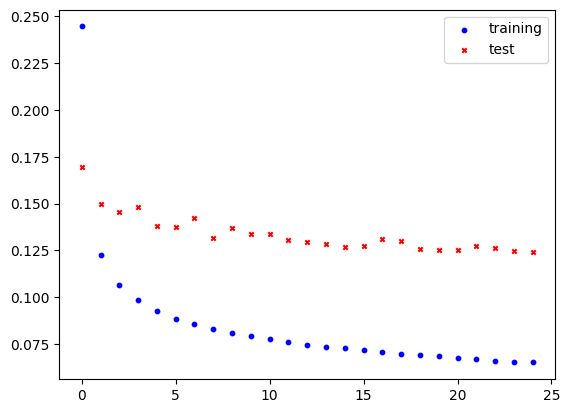

In [56]:
features = rctest95.shape[-1]


modelo_pca95_cs = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_95_cs')


modelo_pca95_cs.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, learning_rate=1e-3, decay=1e-8,))

saveas = 'modelo_pca95_cs'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.keras', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca95_cs.fit(rctraval95,ytraval, validation_data=(rctest95,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

In [57]:
modelo_pca80_cs = tf.keras.models.load_model('modelo_pca80_cs.keras')
modelo_pca95_cs = tf.keras.models.load_model('modelo_pca95_cs.keras')

483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


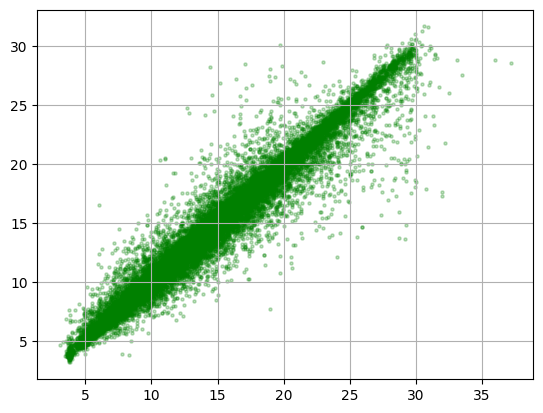

1.0050648689432928
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


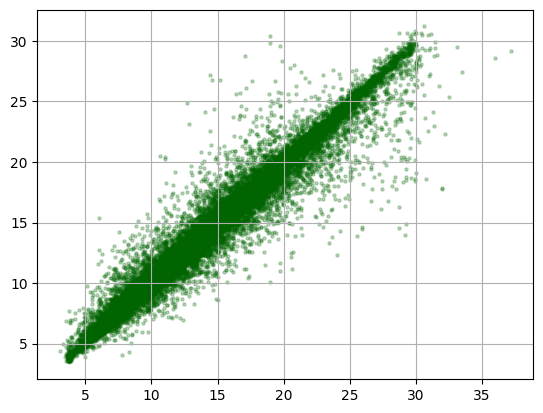

0.9820711714559598


In [58]:
ptestnn = modelo_pca80_cs.predict(rctest80)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='green', alpha=0.25)
plt.grid()
plt.show()
    
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(rmse)

ptestnn = modelo_pca95_cs.predict(rctest95)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='darkgreen', alpha=0.25)
plt.grid()
plt.show()
    
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(rmse)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


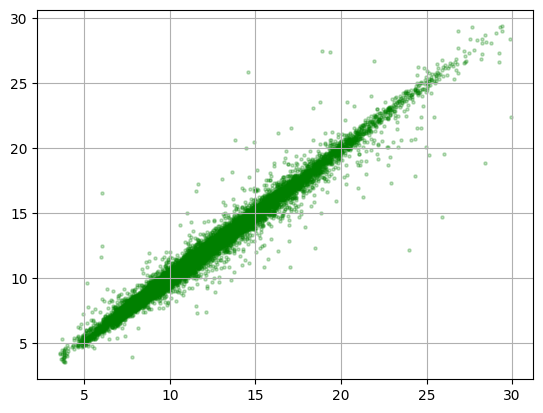

0.5842281805458164
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


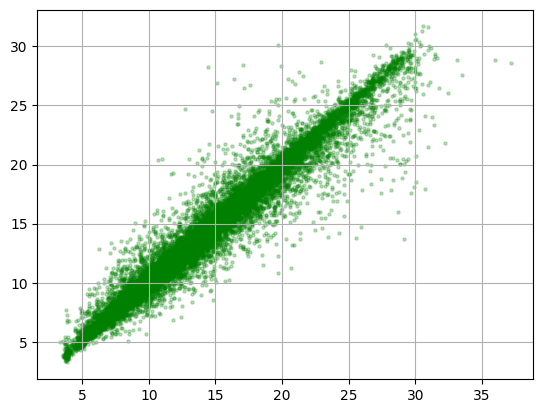

1.1623424454841589
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


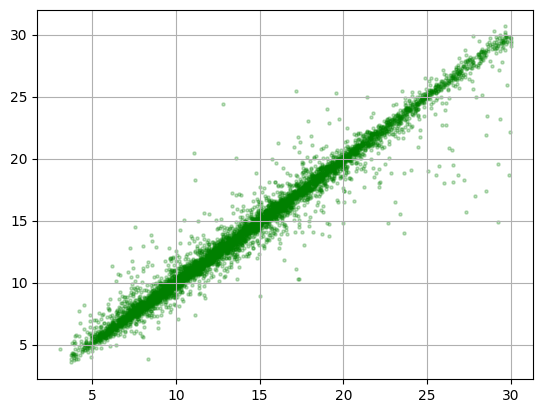

0.9697648059236377
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


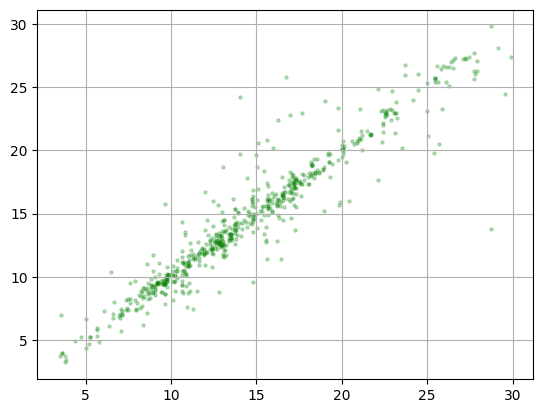

1.6311878192338958
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


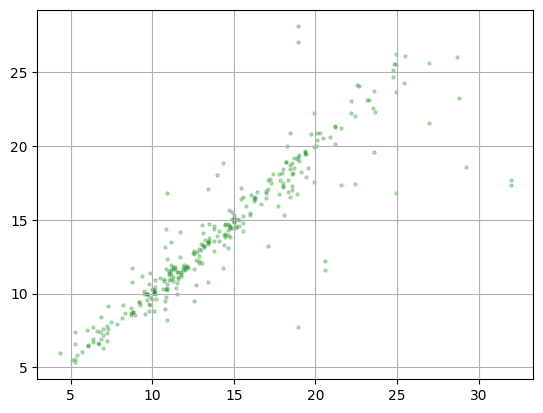

2.2278684966422633
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


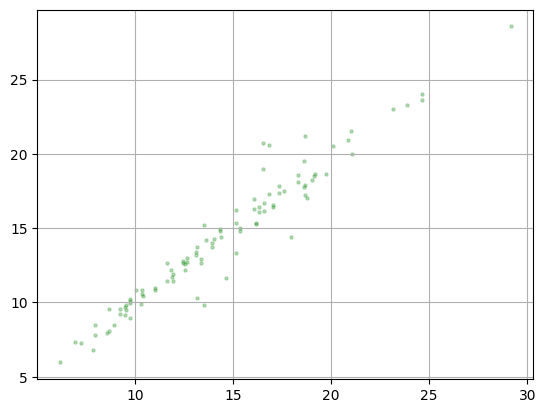

1.1121507073125343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


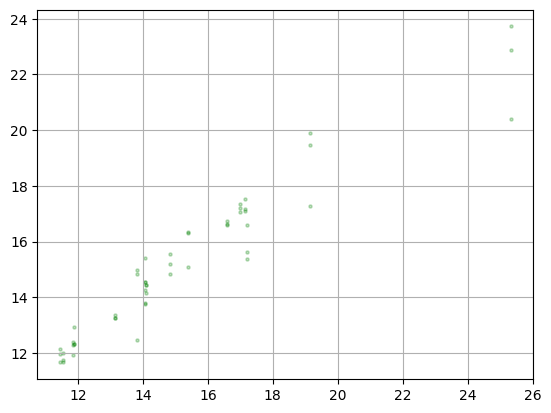

1.051959162018971
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


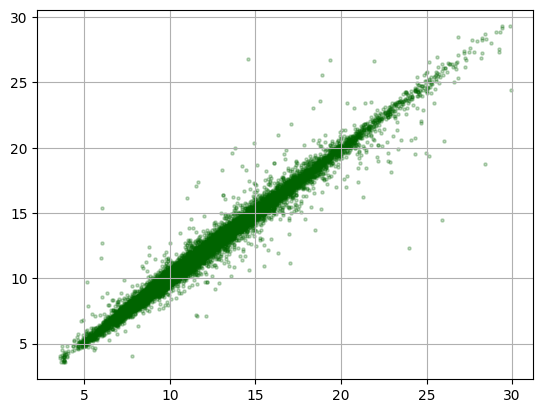

0.560062812376923
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


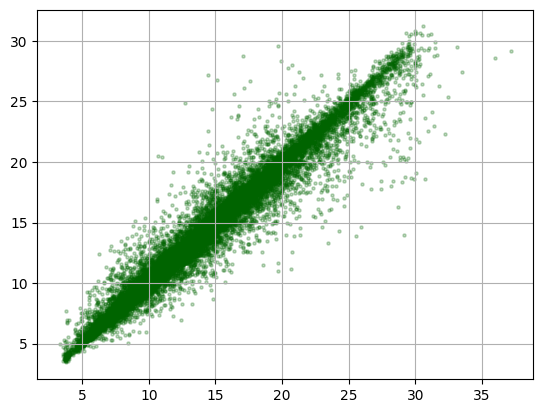

1.1399501108708725
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


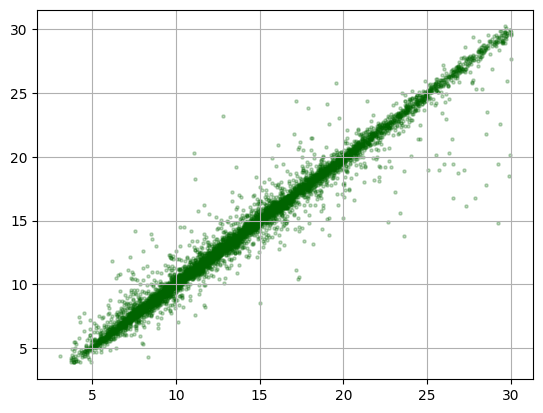

0.9341406507259852
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


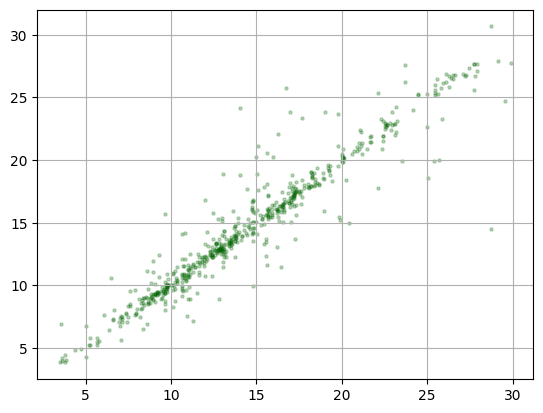

1.6360695841220905
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


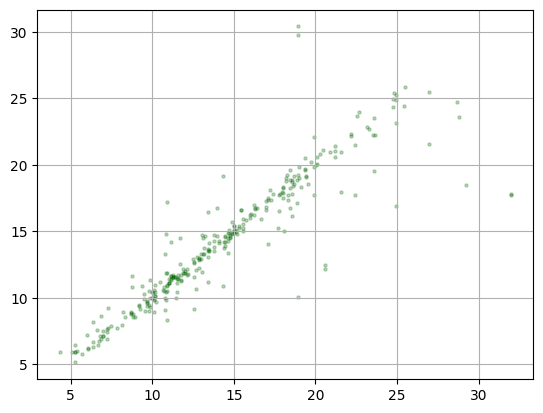

2.2207259664388737
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


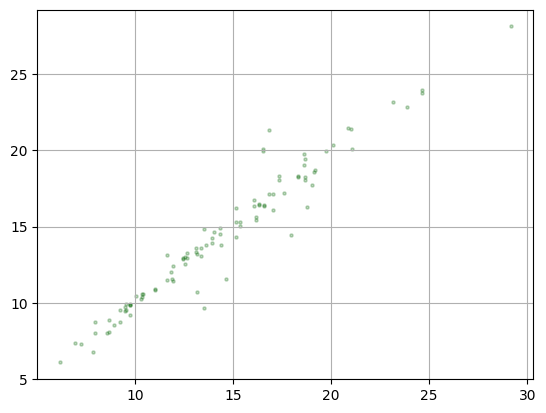

1.10268819192789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


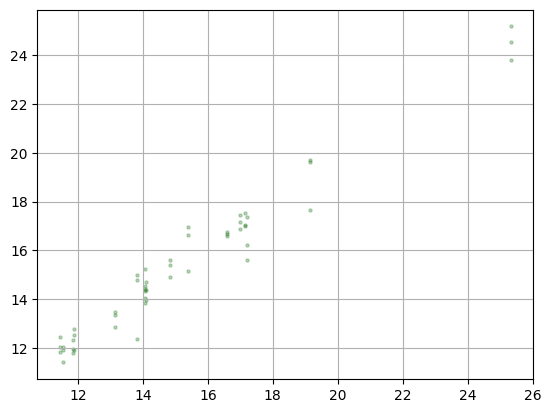

0.699213312545429


In [59]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : rctest80[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca80_cs.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='green', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : rctest95[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca95_cs.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='darkgreen', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)